In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from IF import *
from proutils import *
from joblib import Parallel, delayed
from torch.utils import data
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F


df = pd.read_csv('data/loan_approval_dataset.csv')
dmem=torch.load('data/embeds_DMloan.pt')

/tmp/ipykernel_2911850/881591563.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMloan.pt')


In [2]:
df=df.drop('loan_id',axis=1)
df[' education'] = LabelEncoder().fit_transform(df[' education'])
df[' self_employed'] = LabelEncoder().fit_transform(df[' self_employed'])
df[' loan_status'] = LabelEncoder().fit_transform(df[' loan_status'])
y = df[' loan_status']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[' loan_status']))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)


In [4]:
class LoanApprovalNN(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, return_embedding=False):
        x = self.relu(self.hidden1(x))
        embedding = self.relu(self.hidden2(x))
        if return_embedding:
            return embedding
        x = self.sigmoid(self.output(embedding))
        return x

# Fit model function
def fit_model(X, y, emb=False):
    model = LoanApprovalNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    if emb:
        model.eval()
        with torch.no_grad():
            embeddings = model(X, return_embedding=True)
        return embeddings
    return model

In [5]:
network=fit_model(X_train, y_train)
# torch.save(network.state_dict(), 'data/main_loan.pth')

Epoch [10/100], Loss: 0.6607
Epoch [20/100], Loss: 0.6522
Epoch [30/100], Loss: 0.6430
Epoch [40/100], Loss: 0.6315
Epoch [50/100], Loss: 0.6171
Epoch [60/100], Loss: 0.5997
Epoch [70/100], Loss: 0.5786
Epoch [80/100], Loss: 0.5537
Epoch [90/100], Loss: 0.5245
Epoch [100/100], Loss: 0.4915


In [ ]:
network = LoanApprovalNN(X_train.shape[1])
# network.load_state_dict(torch.load('data/main_loan.pth', weights_only=True))
network.eval()
print("Model Loaded")

In [6]:

network.eval()
embeddings=network(X_test, return_embedding=True)
mod_pred = (network(X_test).detach()>0.5).int().numpy()
with torch.no_grad():
    predictions = network(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 81.15%


In [7]:

DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(42)    
module = LiSSAInfluenceModule(
    model=network,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [8]:
test_idxs = list(range(len(y_test)))
train_idxs = list(range(len(y_train)))

In [ ]:
L2_WEIGHT = 1e-4
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
np.save('influence_scores_loan100.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

In [9]:
# np.save('data/influence_scores_loan100.npy', influence_scores)
influence_scores=np.load("data/influence_scores_loan100.npy")

In [10]:
def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], torch.tensor(mod_pred[prototypes], dtype=torch.float32))

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = (smodel(X_test).detach()>0.5).int().numpy()
        accuracy = (outputs == mod_pred).sum().item() / len(y_test)
    return accuracy

100%|██████████| 8/8 [00:00<00:00, 349.71it/s]


Epoch [10/100], Loss: 0.5656
Epoch [20/100], Loss: 0.5387
Epoch [30/100], Loss: 0.5100
Epoch [10/100], Loss: 0.6122
Epoch [40/100], Loss: 0.4775
Epoch [20/100], Loss: 0.5905
Epoch [50/100], Loss: 0.4426
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5540
Epoch [60/100], Loss: 0.4071
Epoch [10/100], Loss: 0.7012
Epoch [10/100], Loss: 0.6602
Epoch [50/100], Loss: 0.5350
Epoch [70/100], Loss: 0.3726
Epoch [10/100], Loss: 0.7719
Epoch [20/100], Loss: 0.6664
Epoch [20/100], Loss: 0.6342
Epoch [60/100], Loss: 0.5139
Epoch [80/100], Loss: 0.3390
Epoch [20/100], Loss: 0.7583
Epoch [30/100], Loss: 0.6299
Epoch [30/100], Loss: 0.6096
Epoch [70/100], Loss: 0.4901
Epoch [10/100], Loss: 0.6540
Epoch [90/100], Loss: 0.3084
Epoch [30/100], Loss: 0.7422
Epoch [40/100], Loss: 0.5863
Epoch [40/100], Loss: 0.5890
Epoch [80/100], Loss: 0.4642
Epoch [20/100], Loss: 0.6287
Epoch [100/100], Loss: 0.2814
Epoch [50/100], Loss: 0.5615
Epoch [40/100], Loss: 0.7222
Epoch [50/100], Loss: 0.5423
Epoch [90/100

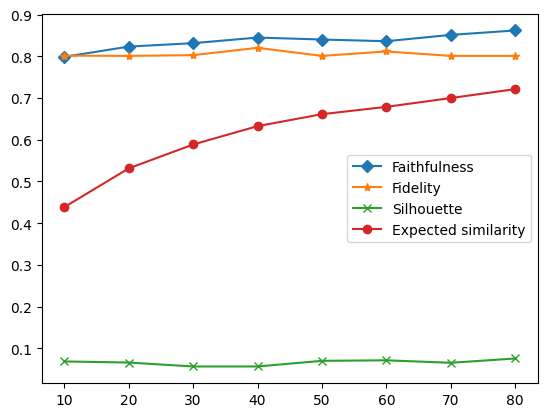

In [11]:
#Experiments with MGloP
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,81,10)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(10, 81, 10), accs, marker='D', label='Faithfulness')
plt.plot(range(10, 81, 10), fids, marker='*', label='Fidelity')
plt.plot(range(10, 81, 10), sil, marker='x', label='Silhouette')
plt.plot(range(10, 81, 10), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [13]:
from aix360.algorithms.protodash import ProtodashExplainer

N_values=range(10,101, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20),
        "mglop2": find_representative_samples(X_test, X_train, influence_scores, N, 20, alpha=0.5),
        "dknn": find_prototypes(embeddings.detach(), mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

100%|██████████| 10/10 [00:00<00:00, 3976.02it/s]


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


connection matrix is ready


/home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [14]:
aide_em=aide(influence_scores, X_train, X_test, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

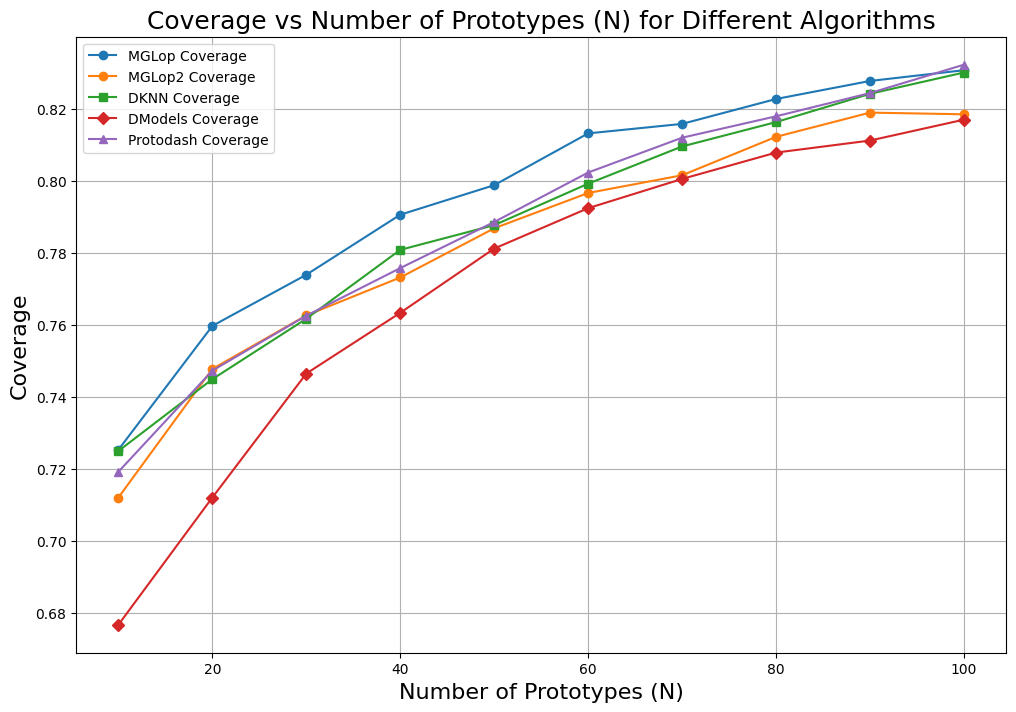

In [15]:
all_protos_np=np.array(all_protos)
mglop_cov=[]
mglop2_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    mglop2_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[4],N=10, bin=False, popularity=True))
   


N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_range, mglop2_cov, marker='o', linestyle='-', label='MGLop2 Coverage')
plt.plot(N_range, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_range, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_range, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

In [36]:
mglop_ev=[]
mglop2_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    # mglop2_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]), surrogate_fidelity(list(all_protos_np[i].values())[1])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]),surrogate_fidelity(list(all_protos_np[i].values())[2])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[4]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[4]), surrogate_fidelity(list(all_protos_np[i].values())[4])])
               


Epoch [10/100], Loss: 0.7641
Epoch [20/100], Loss: 0.7250
Epoch [30/100], Loss: 0.6928
Epoch [40/100], Loss: 0.6606
Epoch [50/100], Loss: 0.6255
Epoch [60/100], Loss: 0.5865
Epoch [70/100], Loss: 0.5456
Epoch [80/100], Loss: 0.5027
Epoch [90/100], Loss: 0.4581
Epoch [100/100], Loss: 0.4135
Epoch [10/100], Loss: 0.5572
Epoch [20/100], Loss: 0.5425
Epoch [30/100], Loss: 0.5209
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4515
Epoch [60/100], Loss: 0.3959
Epoch [70/100], Loss: 0.3350
Epoch [80/100], Loss: 0.2764
Epoch [90/100], Loss: 0.2245
Epoch [100/100], Loss: 0.1829
Epoch [10/100], Loss: 0.7250
Epoch [20/100], Loss: 0.7083
Epoch [30/100], Loss: 0.6947
Epoch [40/100], Loss: 0.6833
Epoch [50/100], Loss: 0.6727
Epoch [60/100], Loss: 0.6608
Epoch [70/100], Loss: 0.6456
Epoch [80/100], Loss: 0.6273
Epoch [90/100], Loss: 0.6070
Epoch [100/100], Loss: 0.5846
Epoch [10/100], Loss: 0.6105
Epoch [20/100], Loss: 0.5857
Epoch [30/100], Loss: 0.5587
Epoch [40/100], Loss: 0.5283
Epoch [50/1

In [20]:
mglop_ev

[[0.7985948477751756, 0.068514474, 0.8009367681498829],
 [0.8231850117096019, 0.06590864, 0.8009367681498829],
 [0.8313817330210773, 0.05644009, 0.8009367681498829],
 [0.844847775175644, 0.05646663, 0.810304449648712],
 [0.8401639344262295, 0.06996943, 0.8009367681498829],
 [0.8360655737704918, 0.071234636, 0.8009367681498829],
 [0.8512880562060889, 0.06528117, 0.8021077283372365],
 [0.8618266978922716, 0.07558879, 0.7084309133489461],
 [0.8583138173302107, 0.07593345, 0.810304449648712],
 [0.8659250585480094, 0.06935643, 0.8009367681498829]]

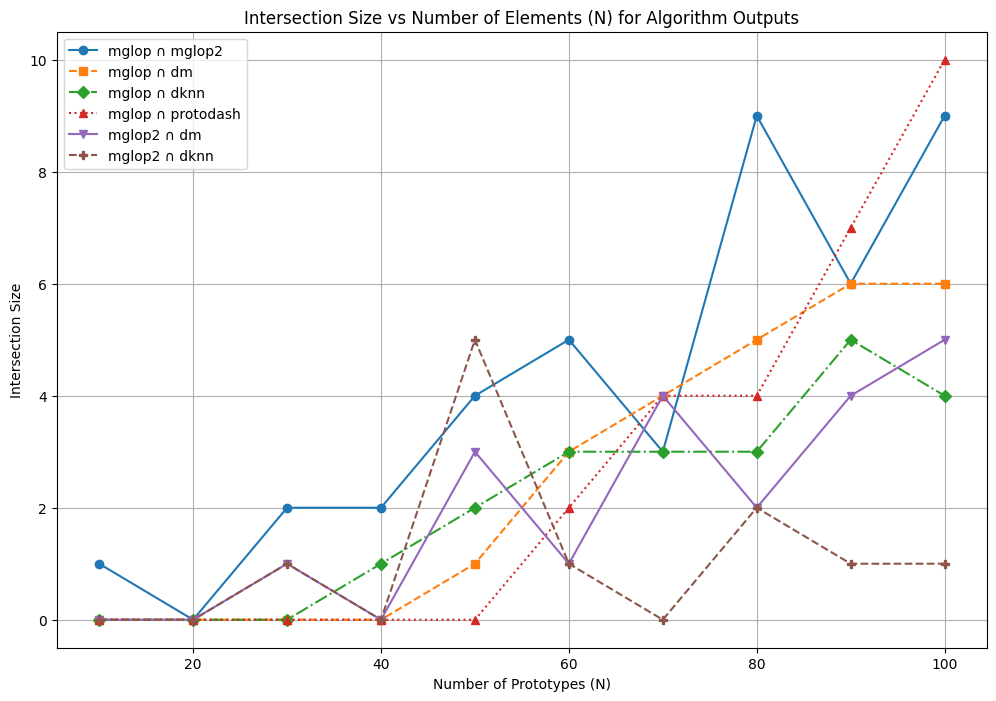

In [21]:
algorithms = ['mglop', 'mglop2', 'dm', 'dknn', 'protodash']
N_range = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_range, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "MGloP-DkNN": [],
    "MGloP-DM": [],
    "MGloP-PDash": [],
    "DkNN-DM": [],
    "DkNN-PDash": [],
    "DM-PDash": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["MGloP-DkNN"].append(ari_12)
    pairwise_aris["MGloP-DM"].append(ari_13)
    pairwise_aris["MGloP-PDash"].append(ari_14)
    pairwise_aris["DkNN-DM"].append(ari_23)
    pairwise_aris["DkNN-PDash"].append(ari_24)
    pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair
plt.figure(figsize=(10, 6))
for pair_name, ari_values in pairwise_aris.items():
    plt.plot(N_values, ari_values, marker='o', label=pair_name)

plt.title('ARI Evolution for Each Pair as Number of Prototypes Increases')
plt.xlabel('Number of Prototypes (k)')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
mglop_ev

[]

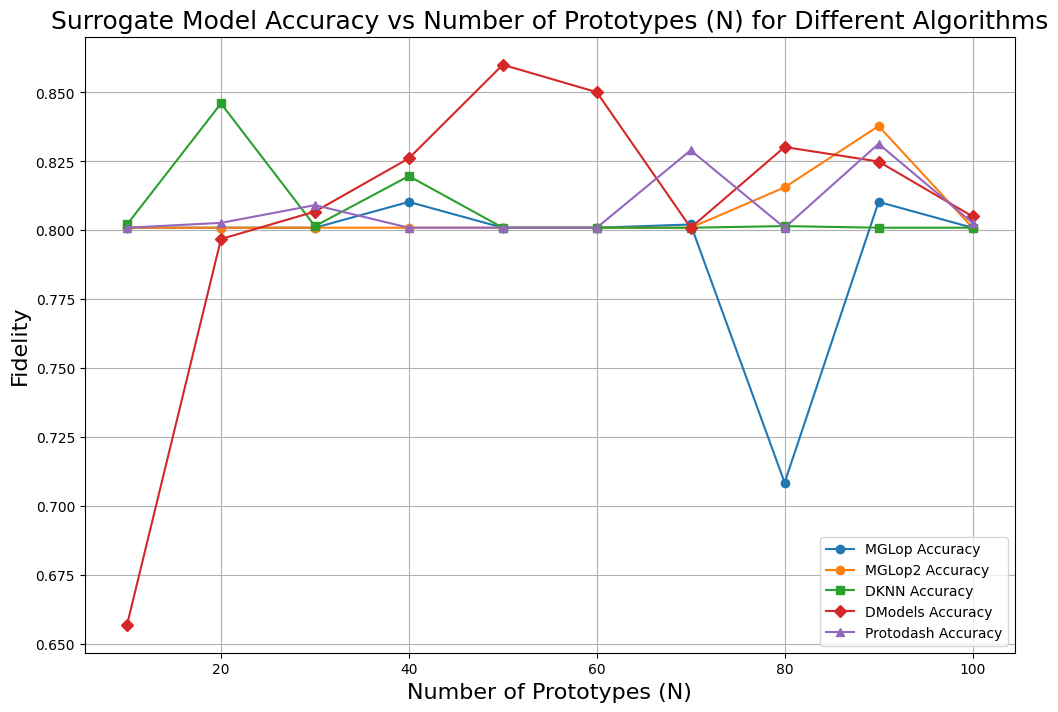

In [23]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[2] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[2] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Accuracy')
plt.plot(N_range, [item[2] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Fidelity", fontsize=16)
plt.title("Surrogate Model Accuracy vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

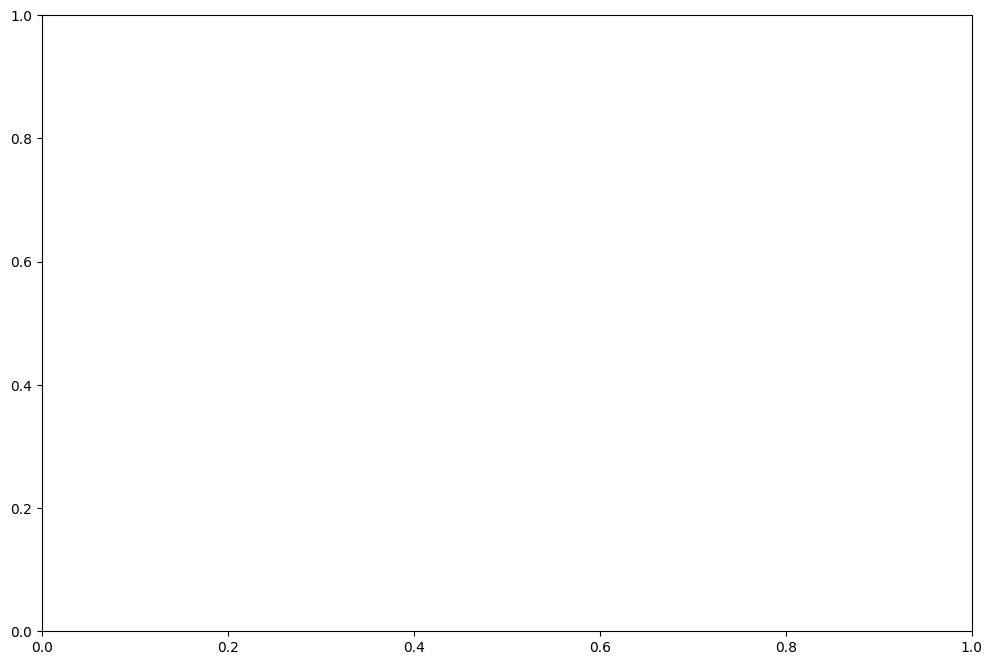

In [37]:
plt.figure(figsize=(12, 8))
mglop_ev=[]
plt.plot(N_range, [item[0] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
# plt.plot(N_range, [item[0] for item in mglop2_ev], marker='o', linestyle='-', label='MGLop2 Accuracy')
plt.plot(N_range, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Nearest Medoid Accuracy")
plt.title("Nearest Medoid Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = range(10, 101, 10)
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []
avg_similarities4 = []

for i in tqdm(range(10)):
    mglop=list(all_protos_np[i].values())[0]
    mglop2=list(all_protos_np[i].values())[1]
    dmodels=list(all_protos_np[i].values())[3]
    dknn=list(all_protos_np[i].values())[2]
    protodash=list(all_protos_np[i].values())[4]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    labels4 = cluster_by_prototypes(X_test, mglop2)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarity4 = expected_inter_cluster_similarity(X_test, labels4)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)
    avg_similarities4.append(avg_similarity4)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='MGloP')
plt.plot(num_prototypes_list, avg_similarities4, marker='o', label='MGloP2')
plt.plot(num_prototypes_list, avg_similarities1, marker='x', label='DkNN')
plt.plot(num_prototypes_list, avg_similarities2, marker='*', label='Dmodels')
plt.plot(num_prototypes_list, avg_similarities3, marker='D', label='ProtoDash')
plt.xlabel('Number of Prototypes')
plt.ylabel('Expected Inter-Cluster Similarity')
plt.title('Expected Inter-Cluster Similarity vs Number of Prototypes')
plt.legend()
plt.grid(True)
plt.show()